In [1]:
import matplotlib as plt

from fastai.conv_learner import *
from experiments.filtervisualizer import *
from cv2 import resize

%matplotlib inline

Set to `True` if you want to use your CPU for computation. 

Set to `False` for using CUDA.

In [2]:
CPU = True

In [3]:
if CPU:
    model = vgg16(pre=True).eval()
else:
    model = vgg16(pre=True).cuda().eval()

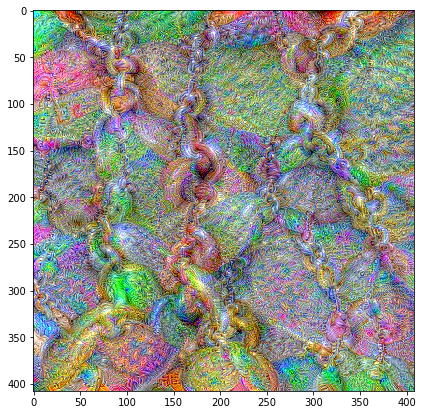

In [5]:
layer_num = 40
layer = list(model.children())[layer_num]
conv_filter = 265

FV = FilterVisualizer(model=model, size=56, upscaling_steps=12, upscaling_factor=1.2, cpu=CPU)
FV.visualize(layer=layer, conv_filter=conv_filter, blur=5, layer_name_plot=layer_num)

img = PIL.Image.open((f'layer_{layer_num}_conv_filter_{conv_filter}.png'))
plt.figure(figsize=(7,7))
plt.imshow(img)